# Using SI Open Access Data on AWS to cluster and search against American Art paintings

## Introduction

In this notebook, we will show how to use the Smithsonian Open Access dataset on AWS, by demonstrating an end-to-end example of filtering metadata, downloading images, and then processing them to produce a cluster representation.

## Using Dask to parse and filter collections metadata on AWS

In this section, we will use Dask and s3fs to process metadata files stored on AWS.

In [1]:
from dask.distributed import Client
import dask.bag as db
import json
from collections import Counter
import time
import numpy as np
import pandas as pd
import s3fs
from PIL import Image
import humanize


Using s3fs, we can list the top-level "directories" in the "smithsonian-open-access" S3 bucket. We can see that the bucket is split between metadata files and media files.

In [2]:
fs = s3fs.S3FileSystem(anon=True)
fs.ls('smithsonian-open-access')

['smithsonian-open-access/media', 'smithsonian-open-access/metadata']

Taking a closer look inside the media directory, we can see that metadata files are organized by Smithsonian unit code. This is really helpful if you would like to work with files from just one unit, like in this case where we will be focusing on paintings from the Smithsonian American Art Museum (SAAM).

In [3]:
metadata = fs.ls('smithsonian-open-access/metadata/edan')
metadata

['smithsonian-open-access/metadata/edan/aaa',
 'smithsonian-open-access/metadata/edan/acah',
 'smithsonian-open-access/metadata/edan/acm',
 'smithsonian-open-access/metadata/edan/cfchfolklife',
 'smithsonian-open-access/metadata/edan/chndm',
 'smithsonian-open-access/metadata/edan/eepa',
 'smithsonian-open-access/metadata/edan/fbr',
 'smithsonian-open-access/metadata/edan/fs',
 'smithsonian-open-access/metadata/edan/fsa',
 'smithsonian-open-access/metadata/edan/fsg',
 'smithsonian-open-access/metadata/edan/hac',
 'smithsonian-open-access/metadata/edan/hmsg',
 'smithsonian-open-access/metadata/edan/hsfa',
 'smithsonian-open-access/metadata/edan/index.txt',
 'smithsonian-open-access/metadata/edan/naa',
 'smithsonian-open-access/metadata/edan/nasm',
 'smithsonian-open-access/metadata/edan/nasmac',
 'smithsonian-open-access/metadata/edan/nmaahc',
 'smithsonian-open-access/metadata/edan/nmafa',
 'smithsonian-open-access/metadata/edan/nmah',
 'smithsonian-open-access/metadata/edan/nmai',
 's

Within each unit, metadata is stored in .txt files in JSONL format. Here we see that there are 256 such files in the SAAM metadata directory, each a little over 100 kilobytes in size.

In [4]:
saam_metadata = fs.ls('smithsonian-open-access/metadata/edan/saam')
print(len(saam_metadata))
for metadata_file in saam_metadata[:5]:
    print(metadata_file)
    print(humanize.naturalsize(fs.du(metadata_file)))

257
smithsonian-open-access/metadata/edan/saam/00.txt
118.3 kB
smithsonian-open-access/metadata/edan/saam/01.txt
152.8 kB
smithsonian-open-access/metadata/edan/saam/02.txt
134.0 kB
smithsonian-open-access/metadata/edan/saam/03.txt
146.6 kB
smithsonian-open-access/metadata/edan/saam/04.txt
132.2 kB


### Dask intro

We will be using the Python Dask library to process this collection of metadata files, because it excels at parallelizing workloads across large numbers of text files, and has built-in support for working with AWS S3 objects.

The first step to using Dask is to set up a "client" that will orchestrate processing across multiple workers. In this specific example, we use 1 worker and 4 threads per worker, because Binder only provide single CPU environments. If you are running this example on your own machine, feel free to crank these numbers up for better performance. 

In [5]:
client = Client(threads_per_worker=4, n_workers=1)
client

Client Scheduler: tcp://127.0.0.1:53379 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 1 Cores: 4 Memory: 17.18 GB


To process nested JSON data, we use the Dask "bag" datatype, and tell it we want to process all .txt files in the SAAM metadata directory. This command will run instantaneously, because Dask uses a "lazy" execution model. This means that most Dask commands build an execution graph to be run later.

In [6]:
saam_metadata_s3 = [f's3://{path}' for path in saam_metadata if 'index.txt' not in path]
saam_metadata_s3[:5]

['s3://smithsonian-open-access/metadata/edan/saam/00.txt',
 's3://smithsonian-open-access/metadata/edan/saam/01.txt',
 's3://smithsonian-open-access/metadata/edan/saam/02.txt',
 's3://smithsonian-open-access/metadata/edan/saam/03.txt',
 's3://smithsonian-open-access/metadata/edan/saam/04.txt']

In [7]:
b = db.read_text(saam_metadata_s3,
                 storage_options={'anon': True}).map(json.loads)

One exception to the "lazy" execution model is the take command, which executes the code immediately to process the first few objects. Here we take just the first object, and then save it to file.

Take a look at how complicated these objects are: [saam_metadata_example.json](https://github.com/sidatasciencelab/siopenaccess/blob/master/saam_metadata_example.json)

In [8]:
saam_example = b.take(1)[0]
with open('saam_metadata_example.json', 'w') as json_out:
    json.dump(saam_example, json_out, indent=2)

In [9]:
#This interactive JSON viewer only works correctly in Jupyter Lab

from IPython.display import display, JSON
display(JSON(saam_example, expanded=True))

<IPython.core.display.JSON object>

Because of how complicated each individual record is, we need to create a Python function to pull out the pieces of data that we want to store and/or filter on later.

In [10]:
def flatten(record):
    """Take a single SAAM metadata record, and pulls out specific pieces of data.

    Parameters
    ----------
    record : dict
        A single SAAM metadata record in highly-nested dictionary format.

    Returns
    -------
    flattened_record: dict
        An un-nested dictionary that only contains the record id, unit code,
        object title, media_count, media_id, topic list, object type, and
        object medium.
    """
    flattened_record = dict()
    flattened_record['id'] = record['id']
    flattened_record['unitCode'] = record['unitCode']
    flattened_record['title'] = record['title']
    media_count = record['content'].get('descriptiveNonRepeating', {}).get('online_media',{}).get('mediaCount',np.nan)
    flattened_record['media_count'] = float(media_count)
    media = record['content'].get('descriptiveNonRepeating', {}).get('online_media',{}).get('media',[])   
    if len(media):
        flattened_record['media_id'] = media[0]['idsId']
        
    topics = record['content'].get('indexedStructured',{}).get('topic',[])
    if len(topics):
        flattened_record['topics'] = '|'.join(topics)
    
    if 'freetext' in record['content']:
        if 'objectType' in record['content']['freetext']:
            for obtype in record['content']['freetext']['objectType']:
                if obtype['label'] == 'Type':
                    flattened_record['object_type'] = obtype['content']
        if 'physicalDescription' in record['content']['freetext']:
            for phys in record['content']['freetext']['physicalDescription']:
                if phys['label'] == 'Medium':
                    flattened_record['medium'] = phys['content']
        if 'name' in record['content']['freetext']:
            for name in record['content']['freetext']['name']:
                if name['label'] == 'Artist':
                    flattened_record['artist'] = name['content']
        if 'date' in record['content']['freetext']:
            for date in record['content']['freetext']['date']:
                if date['label'] == 'Date':
                    flattened_record['date'] = str(date['content'])
            
    return flattened_record

Here we test out this `flatten` function by passing it the single record we pulled out earlier with the `take` command. You can see how it converted the highly-nested format into a single level dictionary with only a few pieces of information.

In [11]:
flattened_example = flatten(saam_example)
flattened_example

{'id': 'edanmdm-saam_1929.8.175.19',
 'unitCode': 'SAAM',
 'title': 'Necklace',
 'media_count': 1.0,
 'media_id': 'SAAM-1929.8.175.19_1',
 'object_type': 'Decorative Arts-Jewelry',
 'medium': 'faience and glass',
 'artist': 'Unidentified',
 'date': '100 B.C.-100 A.D.'}

Finally, we send all 12,542 metadata records through the `flatten` function with the Dask `map` function, and ensure that the command is actually executed by using the `compute` function. Since `flatten` returns a single-level dictionary, we can convert the results of into a table using the `to_dataframe` function. Then we run `head` to look at the first 5 rows of this table.

In [12]:
saam_json = b.map(flatten).compute()
saam_df = pd.DataFrame(saam_json)
saam_df.head()

,id,unitCode,title,media_count,media_id,object_type,medium,artist,date,topics
0,edanmdm-saam_1929.8.175.19,SAAM,Necklace,1.0,SAAM-1929.8.175.19_1,Decorative Arts-Jewelry,faience and glass,Unidentified,100 B.C.-100 A.D.,NaN
1,edanmdm-saam_1998.160.3,SAAM,"Untitled from ""Atlantic and Great Western Rail...",NaN,NaN,Photography-Photoprint,albumen silver print,"J. F. Ryder, born Ithaca, NY 1826-died Clevela...",1860,Bridges|Atlantic and Great Western Railroad|Ra...
2,edanmdm-saam_1996.63.144,SAAM,"A Boston Watering-Cart, from Ballou's Pictoria...",1.0,SAAM-1996.63.144_1,Graphic Arts-Print,wood engraving on paper,"Winslow Homer, born Boston, MA 1836-died Prout...",1857,Commercial|Architecture|Occupations|Street swe...
3,edanmdm-saam_2000.47.13,SAAM,Gentleman in Brown Velvet with Patterned Waist...,1.0,SAAM-2000.47.13_1,Photography-Photoprint,salted paper print with applied color,Unidentified,ca. 1848,Figure male
4,edanmdm-saam_1929.6.46,SAAM,Head of a Young Girl,1.0,SAAM-1929.6.46_1,Painting-Miniature,watercolor on ivory,"Lucia Fairchild Fuller, born Boston, MA 1870-d...",ca. 1900,Women|Portraits


Taking a look at the structure of the `pandas` dataframe, we can see that some of the data fields are null.

In [13]:
saam_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12901 entries, 0 to 12900
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           12901 non-null  object 
 1   unitCode     12901 non-null  object 
 2   title        12901 non-null  object 
 3   media_count  12224 non-null  float64
 4   media_id     12224 non-null  object 
 5   object_type  12901 non-null  object 
 6   medium       12459 non-null  object 
 7   artist       12593 non-null  object 
 8   date         10944 non-null  object 
 9   topics       11528 non-null  object 
dtypes: float64(1), object(9)
memory usage: 1008.0+ KB


In [14]:
s3_media_saam = fs.ls('smithsonian-open-access/media/saam')
s3_media_saam_ids = []
for s3_path in s3_media_saam:
    if s3_path.endswith('.jpg'):
        edan_id = s3_path.rstrip('.jpg').split('/')[-1]
        s3_media_saam_ids.append(edan_id)
print(len(s3_media_saam_ids))

15681


In [15]:
saam_df = saam_df[saam_df['media_id'].isin(s3_media_saam_ids)]
saam_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12045 entries, 0 to 12900
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           12045 non-null  object 
 1   unitCode     12045 non-null  object 
 2   title        12045 non-null  object 
 3   media_count  12045 non-null  float64
 4   media_id     12045 non-null  object 
 5   object_type  12045 non-null  object 
 6   medium       11692 non-null  object 
 7   artist       11866 non-null  object 
 8   date         10261 non-null  object 
 9   topics       11177 non-null  object 
dtypes: float64(1), object(9)
memory usage: 1.0+ MB


Let's look at the most common "object_type" and "medium" combinations amongst all SAAM works of art. We can see that the most common type of art is a painting created with oil on canvas.

In [16]:
saam_df.groupby(['object_type','medium']).size().sort_values(ascending=False).head(20)

object_type             medium                          
Painting                oil on canvas                       1647
                        watercolor on paper                  849
Drawing                 pencil on paper                      648
Graphic Arts-Print      wood engraving on paper              440
Drawing                 drawing                              354
Painting-Miniature      watercolor on ivory                  350
Photography-Photoprint  albumen silver print                 264
Graphic Arts-Print      lithograph                           238
                        etching on paper                     213
Drawing                 pencil                               199
Sculpture               plaster                              198
Graphic Arts-Print      etching                              191
Decorative Arts-Glass   glass                                171
Painting                watercolor                           143
Graphic Arts-Print      engraving

Since works of art have multiple topics listed, it is slightly more complicated to look at the most common topics.

In [17]:
def count_topics(topic_column):
    """
    Take the '|'-concatenated column from a pandas dataframe, and expand
    it into a Counter object to see the most common individual topics.

    Parameters
    ----------
    topic_column : pandas Series
        A column from a metadata table. It is expected that multiple topics
        are separated with a pipe symbol.

    Returns
    -------
    topic_counts: Counter
        A Python Counter object of each unique topic, and the number of times
        that it is listed.
    """
    topic_list = []
    topics_entries = topic_column.dropna().tolist()
    for topics_entry in topics_entries:
        topics = topics_entry.split('|')
        if len(topics):
            topic_list += topics
    topic_counts = Counter(topic_list)
    return topic_counts

Out of 12,542 works of art, there are 4,016 unique topics totally 56,927 total topics listed. We can see that "Landscapes" is the most common topic.

In [18]:
topic_counts = count_topics(saam_df['topics'])

print(len(topic_counts))
topic_counts.most_common(20)

4013


[('Landscapes', 3361),
 ('Architecture', 2495),
 ('Portraits', 2417),
 ('Figure group', 2197),
 ('Men', 1958),
 ('Occupations', 1518),
 ('Ethnicity', 1377),
 ('Animals', 1352),
 ('Figure female', 1123),
 ('Women', 1052),
 ('Clothing and dress', 1003),
 ('Figure male', 810),
 ('Botanical study', 775),
 ('Religion', 745),
 ('Domestic', 718),
 ('Nudity', 696),
 ('Cityscapes', 633),
 ('Recreation', 562),
 ('Dress accessories', 559),
 ('Children', 517)]

Since 11,561 images is a lot to process, let's try to filter out all art that include people.

In [19]:
include_topics = ['Landscapes','Architecture','Animals']
exclude_topics = ['Portraits','Nudity','Ethnicity','Men','Women','Children',
                'Figure male','Figure female','Figure group',
                 'Botanical study']
include_regex = '|'.join(include_topics)
exclude_regex = '|'.join(exclude_topics)
filtered_df = saam_df[(saam_df['topics'].str.contains(include_regex, regex=True).fillna(False)) & \
                 (~saam_df['topics'].str.contains(exclude_regex, regex=True).fillna(False))]
filtered_df.head()

,id,unitCode,title,media_count,media_id,object_type,medium,artist,date,topics
18,edanmdm-saam_1929.6.144,SAAM,"The Brook, Greenwich, Connecticut",1.0,SAAM-1929.6.144_1,Painting,oil on canvas,"John Henry Twachtman, born Cincinnati, OH 1853...",ca. 1890-1900,Landscapes|Rivers|Greenwich
20,edanmdm-saam_1983.83.171,SAAM,Rhine at the Lurlei,1.0,SAAM-1983.83.171_1,Drawing,pencil on paper,"George Elbert Burr, born Monroe Falls, OH 1859...",1900,Lurlei|Landscapes|Art|Rhine River|Rivers
25,edanmdm-saam_1991.56.271,SAAM,Nanfio,1.0,SAAM-1991.56.271_1,Drawing,pencil on paper,"Miner Kilbourne Kellogg, born Manlius Square, ...",1843,Mountains|Landscapes
30,edanmdm-saam_1967.136.6,SAAM,Mountains in Colorado,1.0,SAAM-1967.136.6_1,Painting,oil on paper mounted on paperboard,"John Frederick Kensett, born Cheshire, CT 1816...",1870,Mountains|Western|Landscapes|Rocks
32,edanmdm-saam_1983.83.55,SAAM,Untitled (transfer drawing for Storm near Timb...,1.0,SAAM-1983.83.55_1,Drawing,pencil on paper,"George Elbert Burr, born Monroe Falls, OH 1859...",ca. 1922,Trees|Western|Weather|Landscapes|Storms|Rocks


After running this filter step, we are left with 1,573 unique topics from 2,816 works of art.

In [20]:
print(len(filtered_df))
filtered_topics = count_topics(filtered_df['topics'])
print(len(filtered_topics))
filtered_topics.most_common(20)

2808
1574


[('Landscapes', 1969),
 ('Architecture', 1190),
 ('Animals', 625),
 ('Mountains', 378),
 ('Rivers', 315),
 ('Trees', 293),
 ('Cityscapes', 284),
 ('Boats and boating', 261),
 ('Domestic', 261),
 ('Waterscapes', 233),
 ('Religion', 224),
 ('Detail', 189),
 ('Dwellings', 174),
 ('Birds', 163),
 ('Coasts', 141),
 ('Time', 126),
 ('Water', 122),
 ('Weather', 121),
 ('Seasons', 119),
 ('Roads', 111)]

Finally, let's limit our search to only paintings. This gives us a target set of 808 images to download and process.

In [21]:
filtered_paintings = filtered_df[(filtered_df['object_type'] == 'Painting') &
                                 (pd.notnull(filtered_df['media_id']))]
filtered_paintings.head()

,id,unitCode,title,media_count,media_id,object_type,medium,artist,date,topics
18,edanmdm-saam_1929.6.144,SAAM,"The Brook, Greenwich, Connecticut",1.0,SAAM-1929.6.144_1,Painting,oil on canvas,"John Henry Twachtman, born Cincinnati, OH 1853...",ca. 1890-1900,Landscapes|Rivers|Greenwich
30,edanmdm-saam_1967.136.6,SAAM,Mountains in Colorado,1.0,SAAM-1967.136.6_1,Painting,oil on paper mounted on paperboard,"John Frederick Kensett, born Cheshire, CT 1816...",1870,Mountains|Western|Landscapes|Rocks
34,edanmdm-saam_1984.50,SAAM,The Departure of the Crusaders,1.0,SAAM-1984.50_2,Painting,oil on canvas,"Victor Nehlig, born Paris, France 1830-died Ne...",1863,Bishop|Crusades|Architecture|Procession|Occupa...
38,edanmdm-saam_1958.5.3,SAAM,"Above Tower Falls, Yellowstone",1.0,SAAM-1958.5.3_1,Painting,watercolor and gouache on paper,"Thomas Moran, born Bolton, England 1837-died S...",1872,Yellowstone National Park|Landscapes|Tower Fal...
55,edanmdm-saam_1983.95.91,SAAM,Untitled (landscape with trees and two cows in...,1.0,SAAM-1983.95.91_1,Painting,oil on canvas,"Edward Mitchell Bannister, born St. Andrews, N...",1895,Trees|Weather|Landscapes|Animals|Cattle|Cloud|...


In [22]:
filtered_paintings.to_csv('saam_painting_metadata.tsv', index=False, sep='\t')

In [23]:
painting_ids = filtered_paintings['media_id'].tolist()
print(len(painting_ids))
painting_ids[:10]

821


['SAAM-1929.6.144_1',
 'SAAM-1967.136.6_1',
 'SAAM-1984.50_2',
 'SAAM-1958.5.3_1',
 'SAAM-1983.95.91_1',
 'SAAM-1973.150_1',
 'SAAM-1985.66.385_1',
 'SAAM-1909.7.51_1',
 'SAAM-1974.69.14_1',
 'SAAM-1978.68_1']

## Download image files from S3

This section of the demo can actually be skipped, since the GitHub repository already has all thumbnails included, and this is the slowest part of the demo (around 4 minutes).

In [24]:
def download_thumbnail(edan_id):
    """
    Opens a full-size image from S3, compresses it to thumbnail, and writes 
    it to disk. Harcoded for SAAM images, and to save to saam_thumbnails directory.

    Parameters
    ----------
    edan_id : string
        The Smithsonian Enterprise Digital Asset Network (EDAN) ID of the object
        to download.

    """
    thumb_size = (500, 500)
    s3_url = f'smithsonian-open-access/media/saam/{edan_id}.jpg'
    file_dest = f'saam_thumbnails/{edan_id}.jpg'
    with fs.open(s3_url,'rb') as s3_image:
        pil_image = Image.open(s3_image)
        pil_image.thumbnail(thumb_size)
        pil_image.save(file_dest)
    return

Un-comment the code block below (by removing the # at the beginning of each line) if you would like to run this download step anyways.

In [25]:
#start = time.time()
#futures = client.map(download_thumbnail, painting_ids)
#results = client.gather(futures)
#end = time.time()
#print(end - start)

In [26]:
from pathlib import Path

downloaded_images = Path('saam_thumbnails/').glob('*.jpg')
downloaded_ids = [image_file.stem for image_file in downloaded_images]

print(len(downloaded_ids))

821


## Producing image feature vectors with TensorFlow

Now that we have all of our painting images downloaded into the "saam_thumbnails" directory, we can do some processing on them.

For this demonstration, we will attempt to use a broad machine learning technique called "unsupervised learning" (https://en.wikipedia.org/wiki/Unsupervised_learning) to cluster similar images together, and learn a little bit about our collection.

Specifically, we will be using a pre-trained photographic image classifier called MobileNetV2 (https://arxiv.org/abs/1801.04381) to extract a numerical "feature vector" representation of each image, which can then be used to calculate image-to-image distances. We will then feed those vectors into the UMAP (https://arxiv.org/abs/1802.03426) algorithm, which reduces our multi-thousand dimensional feature space down to an easy-to-interpret 2-dimensional representation.

In [27]:
import tensorflow as tf
from umap import UMAP
import os
from PIL import Image
from sklearn.decomposition import PCA
from sklearn.preprocessing import minmax_scale
import matplotlib.pyplot as plt
%matplotlib inline

First, we use the TensorFlow Keras deep learning library to load the pre-trained MobileNetV2 ImageNet image classification model. This model was trained on the ImageNet (https://en.wikipedia.org/wiki/ImageNet) benchmark image dataset that contains millions of photographic images from 1000 labeled categories. This model consists of over 150 connected "layers" (this is where the deep in deep learning comes from) that each performs computational transformations on the image data to eventually return a prediction of which label category an image belongs to. The final layer, called "predictions" in the summary output below, takes the numerical representation of the image and provides "probabilities" for each of the 1000 category classes.

In [28]:
mobilenet_base = tf.keras.applications.MobileNetV2(include_top=True, 
                                                   weights='imagenet', 
                                                   pooling='avg')

In [29]:
layer_strings = []
mobilenet_base.summary(print_fn = lambda x: layer_strings.append(x))
print('\n'.join(layer_strings[:15]))
print('\n...\n')
print('\n'.join(layer_strings[-15:]))

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

However, for the use case of clustering, we're not necessarily after the classifications. So we remove the final layer from the model, and save this new model as "mobilenet_features".

In [30]:
mobilenet_features = tf.keras.Model(inputs=mobilenet_base.input, 
                                    outputs=mobilenet_base.layers[-2].output)

Next, we create a Python function that will take an image path, resize the image to the specified MobileNetV2 input size (224 x 224 pixels), and then convert it to a 3-dimensional matrix of values (a 2-dimensional pixel value matrix for the Red, Green, and Blue color "channels" of each image).

In [31]:
def path_to_array(image_path):
    """
    Reads in an image from disk, resizes it using the Pillow library, converts
    it to a Numpy array, and then runs MobileNetV2-specific preprocessing.

    Parameters
    ----------
    image_path : string
        Local file path to an image file.

    Returns
    -------
    im: Numpy array
        A processed Numpy array that is ready to be fed into the MobileNetV2
        Keras model.
    """
    pil_image = Image.open(image_path).resize((224,224), Image.ANTIALIAS)
    np_image = np.array(pil_image)
    np_image = np.expand_dims(np_image, axis=0)
    im = tf.keras.applications.mobilenet_v2.preprocess_input(np_image)
    return im

Next, we run all of our images through this model and then "stack" all of these image matrices together into a single matrix, so that we can take advantage of the model's batch prediction functionality. Finally, we feed this image matrix into the "mobilenet_features" predict function to return a 1280-value "feature vector" interpretation of the input image.

In [32]:
start = time.time()
images = []
for image_id in downloaded_ids:
    painting_path = f'saam_thumbnails/{image_id}.jpg'
    img = path_to_array(painting_path)
    images.append(img)
    
image_stack = np.vstack(images)
feature_vector = mobilenet_features.predict(image_stack, batch_size=32)
end = time.time()
print(end - start)

19.24826192855835


We can see we now have an 808 (1 entry for each of 808 filtered paintings) x 1280 (from the MobileNetV2 feature vector) matrix.

In [33]:
feature_vector.shape

(821, 1280)

In [34]:
with open('saam_painting_feature_vectors.npy','wb') as np_out:
    np.save(np_out, feature_vector)

## Clustering images with UMAP

Now that we have 808 feature vectors, we can process them with the UMAP algorithm to cluster similar images together. We can see in this graph, which plots each image as a semi-transparent point on a scatterplot, that there are certain areas where many paintings cluster very closely together.

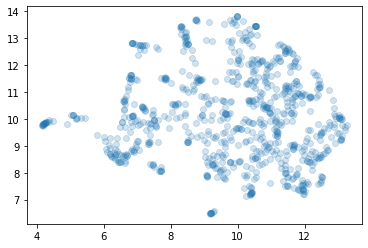

In [35]:
embedding = UMAP(n_neighbors=6, 
                 min_dist=0.01, 
                 metric='correlation').fit_transform(feature_vector)

plt.scatter(embedding[:,0], embedding[:,1],
            alpha=0.2)

Next, we take these image "locations" from the UMAP output, and convert these into a normalized table.

In [36]:
embedding_normalized = minmax_scale(embedding)
df = pd.DataFrame(embedding_normalized, index=downloaded_ids, columns = ['x','y'])
df.head()

,x,y
SAAM-2000.50_1,0.611256,0.877219
SAAM-1983.95.90_2,0.810559,0.820301
SAAM-1977.1.7_1,0.829147,0.774826
SAAM-1929.6.76_2,0.878034,0.588411
SAAM-1985.66.389_1,0.855343,0.115208


In [37]:
df = df.sample(frac=1, random_state=100)
df.head()

,x,y
SAAM-1985.66.395_1,0.821040,0.174896
SAAM-1970.12_1,0.592339,0.265167
SAAM-1970.290_1,0.572762,0.396616
SAAM-1985.66.499_1,0.660152,0.888657
SAAM-1980.133.17_2,0.517357,0.490671


Next, we create a 2500 x 5000 pixel blank "canvas" and then convert those UMAP locations into canvas locations, where we "paste" each of our painting images.

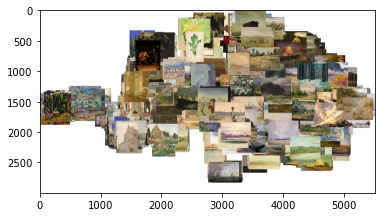

In [38]:
CANVAS_HEIGHT = 2500
CANVAS_WIDTH = 5000
canvas = np.full((CANVAS_HEIGHT+500,CANVAS_WIDTH+500,3),255, dtype=np.uint8)

THUMBNAIL_SIZE = 500,500

for row in df[::-1].itertuples():
    image_path = os.path.join('saam_thumbnails', row.Index) + '.jpg'
    x_pos = round(row.x * CANVAS_WIDTH)
    y_pos = CANVAS_HEIGHT - round(row.y * CANVAS_HEIGHT)

    pil_image = Image.open(image_path)
    pil_image.thumbnail(THUMBNAIL_SIZE)
    np_image = np.array(pil_image)
    canvas[y_pos:np_image.shape[0]+y_pos,
           x_pos:np_image.shape[1]+x_pos] = np_image    
plt.imshow(canvas)

That tiny plot in this notebook is hard to see clearly, so let's output it to file so that we can zoom in on the details … and maybe print out a poster if you like.

In [39]:
saam_umap = Image.fromarray(canvas)
saam_umap.save('saam_umap.png')

## Searching for semantically similar paintings using Annoy

Now that we've "vectorized" the 808 SAAM paintings using the MobileNetV2 model, we can use these vectors as representatives to search against. This type of search can be done using a nearest neighbor algorithm. Specifically, Spotify has implemented this algorithm for quickly matching similar song vectors. They have open sourced this implementation, called Annoy (Approximate Nearest Neighbors Oh Yeah), as a Python library.

In [40]:
from annoy import AnnoyIndex

We will use the AnnoyIndex functionality to produce a feature vector search index from the vectors we produced earlier.

In [41]:
painting_index = AnnoyIndex(1280, metric='angular')
for idx, feature in enumerate(feature_vector):
    painting_index.add_item(idx, feature)
painting_index.build(10) #Build index with 10 trees

True

Ok, now that we have a search index built, let's find another image to search against it. For this example, I'll go back to the original flattened dataset we created (of over 12,000 objects), before we filtered to landscape paintings. Let's try to find some photos of Yosemite.

In [42]:
yosemite_photos = saam_df[(saam_df['object_type'] == 'Photography-Photoprint') &
                           (saam_df['title'].str.lower().str.contains('yosemite'))]
print(len(yosemite_photos))
yosemite_photos.head()

14


,id,unitCode,title,media_count,media_id,object_type,medium,artist,date,topics
42,edanmdm-saam_1994.91.281,SAAM,"The Vernal and Nevada Falls, from Glacier Poin...",1.0,SAAM-1994.91.281_1,Photography-Photoprint,albumen silver print,"Isaiah West Taber, born Bedford, MA 1830-died ...","ca. 1870, printed ca. 1875",Landscapes|Vernal Falls|Waterfalls|Bird's eye ...
1588,edanmdm-saam_1994.89.1,SAAM,Valley of the Yosemite from Union Point,1.0,SAAM-1994.89.1_1,Photography-Photoprint,albumen silver print,"Eadweard Muybridge, born Kingston-upon-Thames,...",1872,Landscapes|Yosemite Valley|Valleys|Rivers|Merc...
2442,edanmdm-saam_1994.91.283,SAAM,"Yosemite Falls, Reflected",1.0,SAAM-1994.91.283_1,Photography-Photoprint,albumen silver print,"Isaiah West Taber, born Bedford, MA 1830-died ...","ca. 1870, printed ca. 1875",Landscapes|Waterfalls|Yosemite Falls|Parks
3103,edanmdm-saam_2009.36.2,SAAM,"Mirror Lake, Yosemite Valley, California",1.0,SAAM-2009.36.2_1,Photography-Photoprint,albumen silver print,"Charles Roscoe Savage, born Southampton, Engla...",1888,Landscapes|Yosemite Valley|Lakes|Mirror Lake
3251,edanmdm-saam_1994.91.279,SAAM,"Half Dome, Yosemite, California",1.0,SAAM-1994.91.279_1,Photography-Photoprint,albumen silver print,"Isaiah West Taber, born Bedford, MA 1830-died ...","ca. 1870, printed ca. 1875",Mountains|Landscapes|Half Dome|Parks


There are 13 matching open access photos, but let's grab the Mirror Lake photo by Charles Roscoe Savage (EDAN ID of SAAM-2009.36.2_1). We can use the 

In [43]:
edan_id = 'SAAM-2009.36.2_1'

thumb_size = (500, 500)
s3_url = f'smithsonian-open-access/media/saam/{edan_id}.jpg'
query_image = f'test_image.jpg'
with fs.open(s3_url,'rb') as s3_image:
    pil_image = Image.open(s3_image)
    pil_image.thumbnail(thumb_size)
    pil_image.save(query_image)

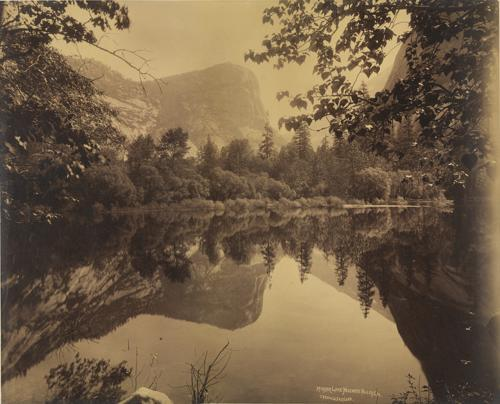

In [44]:
from IPython import display

display.Image(query_image)

The first thing we'll need to do is produce a 1280 MobileNetV2 feature vector for this image.

In [45]:
query_array = path_to_array(query_image)
query_vector = mobilenet_features.predict(query_array).squeeze()
query_vector.shape

(1280,)

In [46]:
closest_3 = painting_index.get_nns_by_vector(query_vector, 3,
                                            include_distances=True)
closest_ids, closest_distances = closest_3
print(closest_ids)
print(closest_distances)

[116, 100, 675]
[0.7721788287162781, 0.7895978093147278, 0.7987999320030212]


In [47]:
import matplotlib.image as mpimg

SAAM-1962.13.59_1


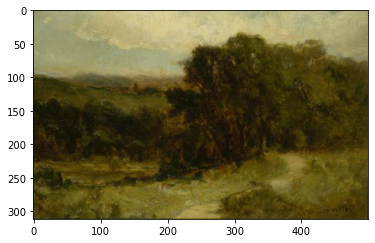

SAAM-1962.13.8_1


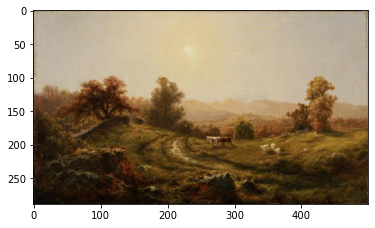

SAAM-1967.6.14_1


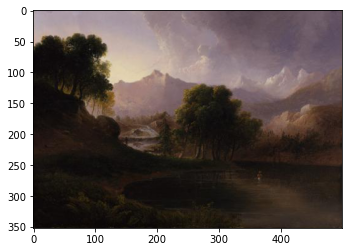

In [49]:
for media_order in closest_ids:
    print(painting_ids[media_order])
    match_image = f'saam_thumbnails/{downloaded_ids[media_order]}.jpg'
    mpl_img = mpimg.imread(match_image)

    plt.imshow(mpl_img)
    plt.show()